<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CNN-for-IMDB-Movie-Review-classification" data-toc-modified-id="CNN-for-IMDB-Movie-Review-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CNN for IMDB Movie Review classification</a></span><ul class="toc-item"><li><span><a href="#Access-IMDB-dataset" data-toc-modified-id="Access-IMDB-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Access IMDB dataset</a></span></li><li><span><a href="#Transform-data-into-sequences-of-integers" data-toc-modified-id="Transform-data-into-sequences-of-integers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform data into sequences of integers</a></span></li><li><span><a href="#Prepare-training--and-validation-data" data-toc-modified-id="Prepare-training--and-validation-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prepare training- and validation data</a></span></li><li><span><a href="#Load-glove-word-embeddings" data-toc-modified-id="Load-glove-word-embeddings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load glove word-embeddings</a></span></li><li><span><a href="#CNN-with-3-Convolutional-Layers" data-toc-modified-id="CNN-with-3-Convolutional-Layers-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>CNN with 3 Convolutional Layers</a></span><ul class="toc-item"><li><span><a href="#Prepare-Embedding-Matrix-and--Layer" data-toc-modified-id="Prepare-Embedding-Matrix-and--Layer-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Prepare Embedding Matrix and -Layer</a></span></li><li><span><a href="#Define-CNN-architecture" data-toc-modified-id="Define-CNN-architecture-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Define CNN architecture</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Train Network</a></span></li></ul></li><li><span><a href="#CNN-with-different-filter-sizes-in-one-layer" data-toc-modified-id="CNN-with-different-filter-sizes-in-one-layer-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>CNN with different filter sizes in one layer</a></span><ul class="toc-item"><li><span><a href="#Prepare-Embedding-Matrix-and--Layer" data-toc-modified-id="Prepare-Embedding-Matrix-and--Layer-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Prepare Embedding Matrix and -Layer</a></span></li><li><span><a href="#Define-Architecture" data-toc-modified-id="Define-Architecture-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Define Architecture</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Train Network</a></span></li></ul></li></ul></li></ul></div>

# CNN for IMDB Movie Review classification
* Author: Johannes Maucher
* Last Update: 20.02.2018

The IMDB Movie Review corpus is a standard dataset for the evaluation of text-classifiers. It consists of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). In a series of notebooks this dataset is applied for the development and evaluation of 
* Convolutional Neural Networks (CNN) (this notebook)
* [Bidirectional LSTMs](K05biDirectionalLSTM.ipynb)
* [Hierarchical Attention Network (HAN)](K05HAN.ipynb)

Goals of the experiments in these notebooks are
* show how to configure advanced network architectures in Keras
* compare these advanced architectures

The current notebook on CNNs does not introduce architectures, which have not already applied before. It is just used as a baseline.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers.merge import Concatenate
from keras.models import Model
os.environ['KERAS_BACKEND']='tensorflow'

Using TensorFlow backend.


## Access IMDB dataset
The [IMDB dataset](https://keras.io/datasets/) is already available in Keras and can easily be accessed by

`imdb.load_data()`. 

The returned dataset contains the sequence of word indices for each review. However, for Hierarchical Attention Network (HAN), not only the two levels *reviews* and *words* are reguired, but in addition the sentence-level. The Keras imdb dataset does not provide sentence information. Therefore, we apply the original dataset from [Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) and preprocess it accordingly:

In [2]:
MAX_SEQUENCE_LENGTH = 1000  # all text-sequences are padded to this length
MAX_NB_WORDS = 20000        # number of most-frequent words that are regarded, all others are ignored
EMBEDDING_DIM = 100         # dimension of word-embedding
VALIDATION_SPLIT = 0.2      # ratio of test-data 

Define a function to normalize all words into lower-case and to remove backslashes.

In [3]:
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

Access locally stored IMDB data (downloaded from Kaggle). Raw-text is extracted by applying [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/):

In [4]:
#data_train = pd.read_csv('/Users/maucher/DataSets/imdb/labeledTrainData.tsv', sep='\t')
data_train = pd.read_csv('../Data/imdb/labeledTrainData.tsv', sep='\t')
print (data_train.shape)

texts = []
labels = []

for idx in range(data_train.review.shape[0]):
    text = BeautifulSoup(data_train.review[idx],"html5lib")
    texts.append(clean_str(text.get_text()))
    labels.append(data_train.sentiment[idx])

(25000, 3)


## Transform data into sequences of integers
Apply the Keras `Tokenizer`-class for representing each review as a sequence of integer word-indices. These sequences actually contain only indices of those words, which belong to the `MAX_NB_WORDS` most frequent words in the corpus.
Then pad all sequences to unique length of `MAX_SEQUENCE_LENGTH`. This means, that longer sequences are cut and shorter sequences are filled with zeros.

In [5]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 81503 unique tokens.


Represent class-labels in one-hot-encoded form:

In [6]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000, 2)


## Prepare training- and validation data
Split data in random training- and test-partiton:

In [7]:
np.random.seed(1234)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set ')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set 
[10047.  9953.]
[2453. 2547.]


## Load glove word-embeddings

In [9]:
GLOVE_DIR = "/Users/maucher/DataSets/glove.6B" #MacBook
#GLOVE_DIR = "../../../../DataSets/glove" #deepthought
#GLOVE_DIR = "./Data/glove.6B"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


## CNN with 3 Convolutional Layers
### Prepare Embedding Matrix and -Layer 

In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Define CNN architecture

In [11]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)

### Train Network

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         8150400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           8204

In [ ]:
print("model fitting - simplified convolutional neural network")
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=128)

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

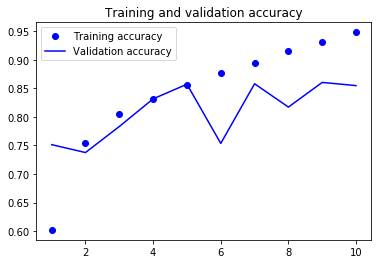

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## CNN with different filter sizes in one layer
In [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf) a CNN with different filter-sizes in one layer has been proposed. This CNN is implemented below:

![KimCnn](https://maucher.home.hdm-stuttgart.de/Pics/KimCnn.png)

Source: [Y. Kim; Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882v2.pdf)

### Prepare Embedding Matrix and -Layer

In [24]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

### Define Architecture

In [25]:
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,kernel_size=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)

### Train Network

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [27]:
print("model fitting - more complex convolutional neural network")
model.summary()
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=50)

model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 100)    8150400     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 998, 128)     38528       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 997, 128)     51328       embedding_2[0][0]                
___________________________________________________

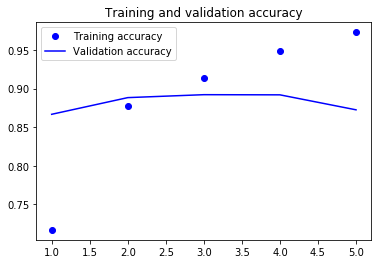

In [28]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
max_val_acc=np.max(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()